# Redshift Lab

Take your time to read through the instructions provided in this notebook.

### _Learning Objectives_

- Understand how to interactivly author Glue ETL scripts using Glue Dev Endpoints & SageMaker notebooks (This portion has already been covered under "Transform Data with AWS Glue" module). 
- Use Glue to do record level transformations and write them to redshift tables. 

### Here are the steps which we will perform

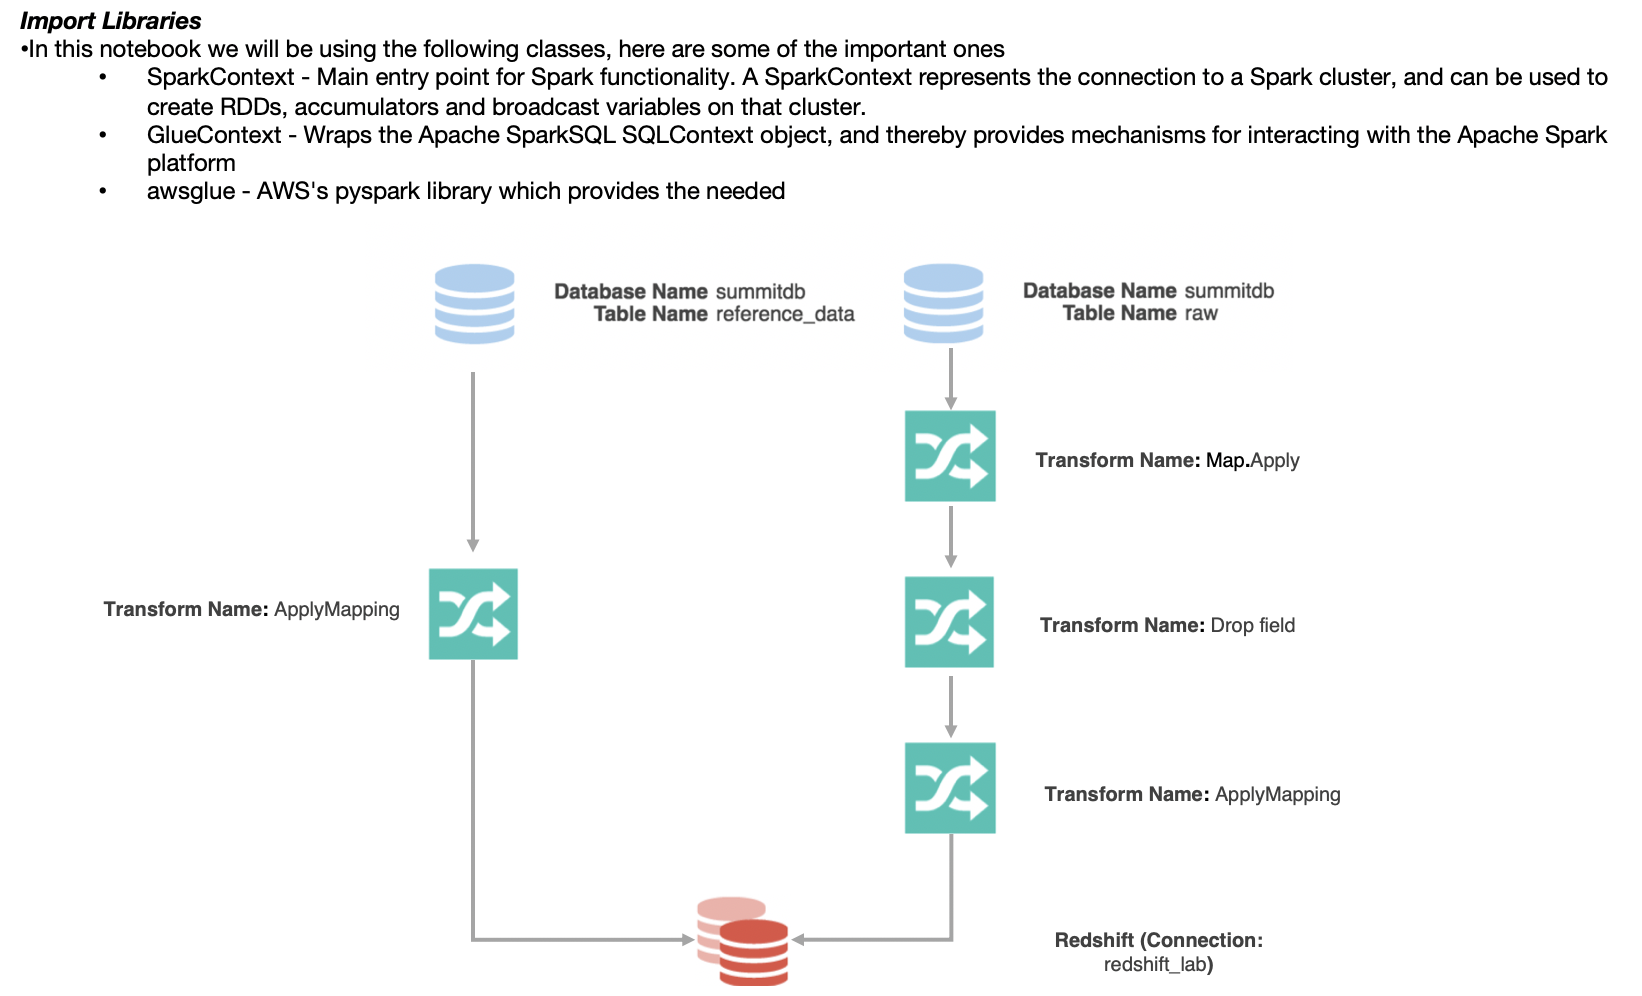

**Execute the code blocks one cell at a time**

Execute Code 🔻


In [ ]:
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

## Exploring your raw dataset
- In this step you will:
    - Create a dynamic frame for your 'raw' table from AWS Glue catalog
    - Explore the schema of the datasets
    - Count rows in raw table
    - View a sample of the data 

### Glue Dynamic Frames Basics

- AWS Glue's dynamic data frames is a powerful data structure.
- They provide a precise representation of the underlying semi-structured data, especially when dealing with columns or fields with varying types.
- They also provide powerful primitives to deal with nesting and unnesting.
- A dynamic record is a self-describing record: Each record encodes its columns and types, so every record can have a schema that is unique from all others in the dynamic frame.
- For ETL, we needed somthing more dynamic, hence we created the Glue Dynamic DataFrames. DDF are an implementaion of DF that relaxes the requiements of having a rigid schema. Its designed for semi-structured data.
- It maintains a schema per-record, its easy to restucture, tag and modify. 


#### Read More : https://docs.aws.amazon.com/glue/latest/dg/aws-glue-api-crawler-pyspark-extensions-dynamic-frame.html

#### Execute Code 🔻


In [ ]:
glueContext = GlueContext(SparkContext.getOrCreate())
spark = glueContext.spark_session

## Crate dynamic frame from Glue catalog
- In this block we are using gluecontext to create a new dynamicframe from glue catalog

Other ways to create dynamicframes in Glue:
- create_dynamic_frame_from_rdd
- create_dynamic_frame_from_catalog
- create_dynamic_frame_from_options

#### Read More:https://docs.aws.amazon.com/glue/latest/dg/aws-glue-api-crawler-pyspark-extensions-glue-context.html

#### Execute Code 🔻


In [ ]:
raw_data = glueContext.create_dynamic_frame.from_catalog(database="analyticsdemodb", table_name="raw")

reference_data = glueContext.create_dynamic_frame.from_catalog(database="analyticsdemodb", table_name="reference_data")

## View schema
- In this step we view the schema of the dynamic frame
- printSchema() – Prints the schema of the underlying DataFrame.

#### Execute Code 🔻


In [ ]:
raw_data.printSchema()

In [ ]:
reference_data.printSchema()

## Count records
- In this step we will count the number of records in the dataframe
- count() – Returns the number of rows in the underlying DataFrame

#### Execute Code 🔻


In [ ]:
print(f'raw_data (count) = {raw_data.count()}')
print(f'reference_data (count) = {reference_data.count()}')

## Show sample raw records
- You can use to method to show samples of data in the datasets
- use show() method to display a sample of records in the frame
- here were are showing the top 5 records in the DF


#### Execute Code 🔻


In [ ]:
raw_data.toDF().show(5)

## Define Transformation Functions
- You can define attribute level transformation functions (**load_time_fn** here). "**load_time_fn**" combines partition column values into one single attribute "**load_time**" in YYYYMMDDHH24 format as an integer. 
- Call all attribute level transformation functions for each record in dynamic dataframe in record level transformation function (**transformRec** here)

#### Execute Code 🔻


In [ ]:
def load_time_fn(partition_0, partition_1, partition_2, partition_3):
    x = partition_0 + partition_1 + partition_2 + partition_3
    x = int(x)
    return x

In [ ]:
def transformRec(rec):
    rec["load_time"] = load_time_fn(rec["partition_0"], rec["partition_1"], rec["partition_2"], rec["partition_3"])
    return rec

## Apply Transformations
- Apply all transformations and store it back in dynamic data frame - "**raw_data_x**"

###### Read more about AWS Glue transforms here : https://docs.aws.amazon.com/glue/latest/dg/built-in-transforms.html

#### Execute Code 🔻


In [ ]:
raw_data_x = Map.apply(frame=raw_data, f=transformRec)

## Show sample transformed raw records
- You can use to method to show samples of data in the datasets
- use show() method to display a sample of records in the frame
- here were are showing the top 5 records in the DF

###### Read more about AWS Glue transforms here : https://docs.aws.amazon.com/glue/latest/dg/built-in-transforms.html

#### Execute Code 🔻


In [ ]:
raw_data_x.toDF().show(5)

## Drop fields
- Once "**load_time**" attribute is generated, we will drop original partition columns using "**drop_fields**" method.
- These were generated by firehose for placing the files in yyyy/mm/dd/hh directory structure in S3
- We will use Glue's in-built **DropFields** transform to drop partition columns

###### Read more about AWS Glue transforms here : https://docs.aws.amazon.com/glue/latest/dg/built-in-transforms.html

#### Execute Code 🔻


In [ ]:
raw_data_clean = raw_data_x.drop_fields(['partition_0', 'partition_1', 'partition_2', 'partition_3'])

## Show sample transformed cleaned raw records
- You can use to method to show samples of data in the datasets
- use show() method to display a sample of records in the frame
- here were are showing the top 5 records in the DF

#### Execute Code 🔻


In [ ]:
raw_data_clean.toDF().show(5)

## Redshift Connection Parameters
- We will use "**analytics_demo**" Glue connection to connect to Redshift cluster.
- We will create connection option for raw table consisting of schema name, table name and database name.
- We will create a temp output directory for Glue to use as a staging area for loading data into Redshift.

#### Execute Code 🔻


In [ ]:
connection_options_raw = {
    "dbtable": "redshift_lab.f_raw_1",
    "database": "dev"
}

output_dir_tmp = "s3://yourname-analytics-demo-bucket/data"

## Cast columns into desired format
- We will explicitly cast all columns into desired datatypes.
- If we dont perform this step, redshift on mismatch will create additional columns and then load the data. Ex: "device_ts" defined as timestamp in Redshift raw table DDL. If we dont cast this column from string to timestamp, a new column will be created in redshift "f_raw_1" table as "device_ts_string" which will have device_ts attribute values while original "device_ts" column which is defined as timestamp will stay blank.


#### Execute Code 🔻



In [ ]:
raw_data_clean = ApplyMapping.apply(
    frame=raw_data_clean,
    mappings=[
        ("uuid", "string", "uuid", "string"),
        ("device_ts", "string", "device_ts", "timestamp"),
        ("device_id", "int", "device_id", "int"),
        ("device_temp", "int", "device_temp", "int"),
        ("track_id", "int", "track_id", "int"),
        ("activity_type", "string", "activity_type", "string"),
        ("load_time", "int", "load_time", "int")
    ]
)

## Load raw data in Redshift

- Finally, we will load cleaned raw data dynamic frame into redshift table - "**redshift_lab.f_raw_1**"
- We will Glue dynamic frame writer class to perform this action.

###### Read more about AWS Glue dynamic frame writer here : https://docs.aws.amazon.com/glue/latest/dg/aws-glue-api-crawler-pyspark-extensions-dynamic-frame-writer.html

#### Execute Code 🔻


In [ ]:
try:
    print("INFO: Loading raw data into Amazon Redshift")
    glueContext.write_dynamic_frame.from_jdbc_conf(
        frame=raw_data_clean,
        catalog_connection="analytics_demo",
        connection_options=connection_options_raw,
        redshift_tmp_dir=output_dir_tmp + "/tmp/"
    )
    print("INFO: Raw data loading into Amazon Redshift complete")
except Exception as e:
    print(f"ERROR: An exception has occurred: {str(e)}")

## Redshift Connection Parameters
- We will use "**analytics_demo**" Glue connection to connect to Redshift cluster.
- We will create connection option for raw table consisting of schema name, table name and database name.

#### Execute Code 🔻


In [ ]:
connection_options_rd = {
    "dbtable": "redshift_lab.d_ref_data_1",
    "database": "dev"
}

## Cast columns into desired format
- We will explicitly cast all columns into desired datatypes.
- If we dont perform this step, redshift on mismatch will create additional columns and then load the data. Ex: "track_id" defined as integer in Redshift raw table DDL. If we dont cast this column from string to int, a new column will be created in redshift "d_ref_data_1" table as "track_id_string" which will have track_id attribute values while original "track_id" column which is defined as int will stay blank.


#### Execute Code 🔻


In [ ]:
reference_data_clean = ApplyMapping.apply(
    frame=reference_data,
    mappings=[
        ("track_id", "string", "track_id", "int"),
        ("track_name", "string", "track_name", "string"),
        ("artist_name", "string", "artist_name", "string")
    ]
)

## Show sample transformed reference records
- You can use to method to show samples of data in the datasets
- use show() method to display a sample of records in the frame
- here were are showing the top 5 records in the DF

#### Execute Code 🔻


In [ ]:
reference_data_clean.toDF().show(5)

## Load reference data in Redshift

- Finally, we will load cleaned reference data dynamic frame into redshift table - "**redshift_lab.d_ref_data_1**"
- We will Glue dynamic frame writer class to perform this action.

###### Read more about AWS Glue dynamic frame writer here : https://docs.aws.amazon.com/glue/latest/dg/aws-glue-api-crawler-pyspark-extensions-dynamic-frame-writer.html

#### Execute Code 🔻


In [ ]:
try:
    print("INFO: Loading reference data into Amazon Redshift")
    glueContext.write_dynamic_frame.from_jdbc_conf(
        frame=reference_data_clean,
        catalog_connection = "analytics_demo",
        connection_options = connection_options_rd,
        redshift_tmp_dir = output_dir_tmp + "/tmp/"
    )
    print("INFO: Reference data loading into Amazon Redshift complete")
except Exception as e:
    print(f"ERROR: An exception has occurred: {str(e)}")

# 😎
=========================

### If you wish you take this notebook and its output back home - you can download / export it:

* In Jupyter's menu bar click **File**:
    * Download As: Notebook(.ipynb) (you can reimport it a jupyter notebook in the future)
    * Download As: HTML (shows code + results in an easy to read format)


# NEXT Steps: Go back to the lab guide

=========================